In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import random_split, DataLoader, TensorDataset

from tqdm import trange

import matplotlib.pyplot as plt

In [2]:
MNIST_ROOT = "/checkpoint/wesbz/Datasets"
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 42
batch_size = 128

In [3]:
torch.manual_seed(seed)

transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

mnist = MNIST(MNIST_ROOT, train=True, download=True, transform=transform)
transform_loader = DataLoader(mnist, batch_size=60_000, shuffle=True)
tfmd_data = next(iter(transform_loader))
mnist_dataset = TensorDataset(tfmd_data[0].to(device), tfmd_data[1].to(device))

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False)

mnist_test = MNIST(MNIST_ROOT, train=False, download=True, transform=transform)
transform_loader = DataLoader(mnist_test, batch_size=10_000, shuffle=False)
tfmd_data = next(iter(transform_loader))
test_data = TensorDataset(tfmd_data[0].to(device), tfmd_data[1].to(device))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
n_h = 10
torch.manual_seed(seed)
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=n_h),
    nn.ReLU(),
    nn.Linear(in_features=n_h, out_features=n_h),
    nn.ReLU(),
    nn.Linear(in_features=n_h, out_features=10)
)

model.to(device)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=10, bias=True)
  (10): ReLU()
  (11): Linear(in_features=10, out_features=10, bias=True)
)

In [5]:
lr = 1e-1
epochs = 10
# Training
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1 / (epoch+1))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)

hist_train_acc = []
hist_train_loss = []

In [6]:
with trange(epochs) as t:
    for _ in t:

        model.train()

        train_loss = 0.0
        correct = 0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        train_loss /= len(train_loader)

        # print(f"Train accuarcy: {100. * correct / total:.3f}%")
        train_acc = 100. * correct / total
        hist_train_acc.append(100. * correct / total)
        hist_train_loss.append(train_loss)

        # scheduler.step()

        t.set_postfix(train_acc=train_acc)

test_loss = 0.0
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)

        test_loss += loss.item()
        _, predicted = y_pred.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

test_loss /= len(test_loader)

print(f"Test accuracy: {100. * correct / total}%")

  0%|                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it, train_acc=99.5]

Test accuracy: 97.85%


In [7]:
model.eval()
first_weights = model[-3].weight.detach().clone()

In [8]:
first_weights
print(torch.linalg.svdvals(first_weights))
print(torch.linalg.eigvals(first_weights))

tensor([1.7864, 1.7398, 1.6188, 1.4724, 1.3909, 1.3505, 0.7764, 0.5099, 0.3884,
        0.1109], device='cuda:0')
tensor([-1.0166+0.4984j, -1.0166-0.4984j,  0.0265+1.0236j,  0.0265-1.0236j,
         1.0064+0.4859j,  1.0064-0.4859j,  0.4233+0.6877j,  0.4233-0.6877j,
         0.3766+0.0000j,  0.5757+0.0000j], device='cuda:0')


In [9]:
replay_test_acc = [correct/total]
replay_test_loss = [test_loss]
replay_mapping = [torch.eye(model[-3].out_features).to(device)]
replay_weights = [model[-3].weight.detach().clone()]
replay_biases = [model[-3].bias.detach().clone()]
replay_sv = torch.linalg.svdvals(replay_weights[-1]).tolist()

In [10]:
model[-3].weight.detach().clone()

tensor([[ 0.2621, -0.3260, -0.2815,  0.1458, -0.4860,  0.4947, -0.1435, -0.2907,
          0.0411,  1.0223],
        [ 0.5987, -0.0845, -0.3801,  0.4264, -0.3993,  0.4066, -0.1862, -0.2786,
          0.3704, -0.2192],
        [ 1.0699, -0.2189,  0.0536,  0.2223,  0.6176, -0.5186,  0.0129,  0.4156,
         -0.0843, -0.3438],
        [-0.0232, -0.0684, -0.3381, -0.5044,  0.8740,  0.9924, -0.1526, -0.3719,
         -0.1242, -0.0229],
        [-0.2520,  0.0657, -0.1531, -0.0641, -0.0658, -0.1311,  0.2289, -0.0237,
         -0.1089, -0.1345],
        [-0.1019,  0.2138,  0.5839,  0.7192, -0.1259,  0.6090, -0.1785, -0.2114,
         -0.4915, -0.6257],
        [-0.0515, -0.1950,  0.0196, -0.1106, -0.0690,  0.2209,  0.2867, -0.1423,
          0.1170, -0.2376],
        [-0.5103, -0.0056, -0.3644,  0.6204,  0.3861,  0.1070,  0.1763,  0.2732,
          0.1415, -0.3259],
        [-0.1250,  0.6150,  1.0195, -0.1856,  0.2832,  0.3232, -0.3078,  0.2497,
          0.5735,  0.1195],
        [-0.2380, -

In [11]:
model[-3].bias.detach().clone()

tensor([ 0.0453, -0.2414,  0.2875,  0.3443, -0.1977, -0.0948, -0.1241, -0.1162,
         0.1580, -0.0761], device='cuda:0')

In [12]:
model[-3].reset_parameters()

In [13]:
model[-3].weight.detach().clone()

tensor([[ 0.0714, -0.3099, -0.0642, -0.2907, -0.2174, -0.0111,  0.1494, -0.0595,
          0.0120, -0.1349],
        [-0.1634,  0.2674,  0.2087, -0.2946, -0.0709, -0.2641,  0.1734, -0.1396,
          0.0088, -0.1854],
        [-0.3116,  0.2372,  0.2961, -0.2403, -0.1915, -0.0315, -0.2839, -0.0068,
          0.2739, -0.0754],
        [-0.2841, -0.1478,  0.0945, -0.1471, -0.2066,  0.2255, -0.1416, -0.1839,
         -0.2713,  0.1708],
        [ 0.0696, -0.0984,  0.3069, -0.0195,  0.2658,  0.1345, -0.2497,  0.1985,
         -0.2472,  0.0695],
        [-0.2055,  0.2154,  0.2343,  0.1446, -0.1555, -0.2108,  0.1436, -0.0641,
         -0.1457,  0.1916],
        [-0.0563, -0.2230, -0.3018, -0.1688, -0.1709, -0.0643, -0.0121, -0.1188,
          0.0772, -0.0910],
        [ 0.0956,  0.2723, -0.1457, -0.2871,  0.3115, -0.1399,  0.0068,  0.0598,
          0.0737, -0.1081],
        [ 0.1920, -0.0025,  0.1251,  0.0915,  0.2567, -0.1081, -0.1991, -0.0919,
          0.1579, -0.1374],
        [ 0.1827,  

In [14]:
model[-3].bias.detach().clone()

tensor([ 0.3085, -0.2347,  0.0393,  0.0140,  0.1546,  0.0604,  0.2939,  0.2517,
         0.1726,  0.1063], device='cuda:0')

  0%|                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s, train_acc=99.7]


Test accuracy: 98.1%


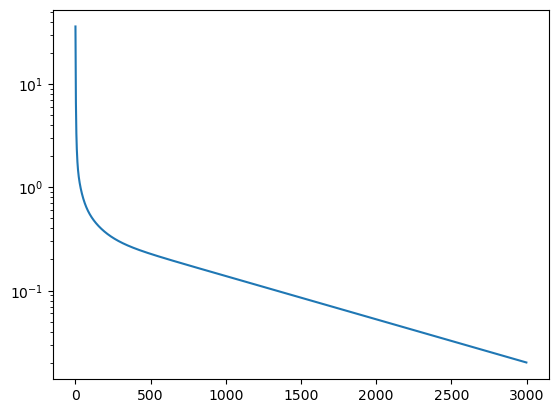

 10%|█████████████████▊                                                                                                                                                                | 1/10 [00:10<01:38, 10.95s/it]

tensor([1.6530, 1.4151, 1.3114, 1.2636, 1.2191, 0.8139, 0.6523, 0.3242, 0.1616,
        0.0491], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 0.9790+0.0000j,  0.3111+0.8847j,  0.3111-0.8847j, -0.6463+0.4999j,
        -0.6463-0.4999j, -0.8046+0.0000j,  0.0742+0.3579j,  0.0742-0.3579j,
        -0.1767+0.2705j, -0.1767-0.2705j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s, train_acc=99.8]


Test accuracy: 98.47%


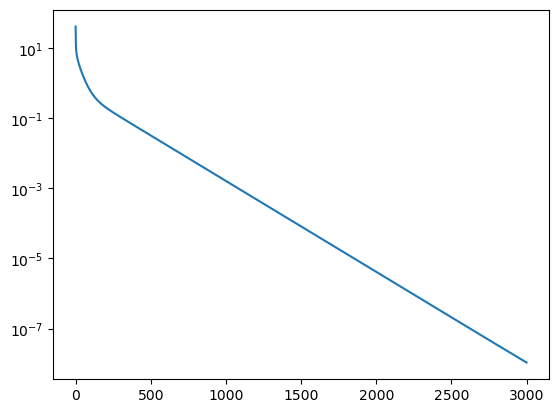

 20%|███████████████████████████████████▌                                                                                                                                              | 2/10 [00:21<01:26, 10.86s/it]

tensor([1.9548, 1.3842, 1.3155, 1.2080, 1.1125, 0.6723, 0.5465, 0.3476, 0.2731,
        0.1222], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 1.3664+0.0000j, -0.7387+0.5061j, -0.7387-0.5061j, -0.1422+0.8509j,
        -0.1422-0.8509j,  0.7491+0.0000j, -0.3916+0.2232j, -0.3916-0.2232j,
         0.2505+0.3187j,  0.2505-0.3187j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


In [15]:
torch.seed()
for replay in trange(10):
    model[-3].reset_parameters()
    with trange(epochs) as t:
        for _ in t:

            model[-3].train()

            train_loss = 0.0
            correct = 0
            total = 0

            for X, y in train_loader:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()

                y_pred = model(X)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = y_pred.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

            train_loss /= len(train_loader)

            # print(f"Train accuarcy: {100. * correct / total:.3f}%")
            train_acc = 100. * correct / total
            hist_train_acc.append(100. * correct / total)
            hist_train_loss.append(train_loss)

            # scheduler.step()

            t.set_postfix(train_acc=train_acc)

    test_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            test_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

    test_loss /= len(test_loader)

    print(f"Test accuracy: {100. * correct / total}%")

    replay_test_acc.append(correct/total)
    replay_test_loss.append(test_loss)
    replay_weights.append(model[-3].weight.detach().clone())
    replay_biases.append(model[-3].bias.detach().clone())

    # Get the mapping
    A = torch.rand(model[-3].out_features, model[-3].out_features).to(device)
    A.requires_grad = True
    map_optimizer = optim.SGD([A], lr=1e-1)
    hist_map_loss = []
    for _ in range(3_000):
        map_optimizer.zero_grad()
        loss = torch.norm(A @ model[-3].weight - first_weights)**2
        loss.backward()
        hist_map_loss.append(loss.item())
        map_optimizer.step()
    plt.figure()
    plt.plot(hist_map_loss)
    plt.yscale("log")
    plt.show(block=False)
    print(torch.linalg.svdvals(model[-3].weight))
    sv = torch.linalg.svdvals(model[-3].weight)
    print(torch.linalg.eigvals(model[-3].weight))
    replay_sv.extend((sv/sum(sv)).tolist())
    replay_mapping.append(A)


In [ ]:
replay_mapping                     

[tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0'),
 tensor([[ 0.4862,  1.7765, -0.5360,  1.0078,  0.4677,  2.0632,  1.0944, -0.2149,
           0.9853,  0.4813],
         [ 0.8770, -1.9772,  1.1926,  0.2204, -1.4127, -2.3230,  0.4641, -0.6945,
           0.8228,  1.0408],
         [-0.9425,  2.9573,  0.2863,  0.2708,  1.2110,  2.3094,  0.2072,  0.5110,
          -0.0897, -0.3649],
         [-0.4457,  2.9566, -1.0898,  1.6924,  1.4167,  1.7325,  0.6027,  0.2968,
           1.3280, -0.2625],
         [ 0.1986, -1.2582,

In [ ]:
U, S, V = torch.linalg.svd(model[-3].weight)

In [ ]:
S

tensor([2.4645, 1.7079, 1.4557, 1.2393, 0.9770, 0.5574, 0.4355, 0.2767, 0.2100,
        0.0678], device='cuda:0', grad_fn=<LinalgSvdBackward0>)

In [ ]:
replay_sv

[[1.7700281143188477,
  1.7104945182800293,
  1.631276249885559,
  1.525507926940918,
  1.3579826354980469,
  1.2822906970977783,
  0.7093722820281982,
  0.5141065716743469,
  0.497064471244812,
  0.0482974648475647],
 0.17231829464435577,
 0.15467500686645508,
 0.14542602002620697,
 0.13896113634109497,
 0.12915180623531342,
 0.10189840942621231,
 0.09742113202810287,
 0.034472376108169556,
 0.02250063046813011,
 0.003175074001774192,
 0.21573945879936218,
 0.16112005710601807,
 0.1533803641796112,
 0.13470345735549927,
 0.11671312153339386,
 0.10621267557144165,
 0.050204817205667496,
 0.032038331031799316,
 0.019014930352568626,
 0.010872786864638329,
 0.17612163722515106,
 0.16138358414173126,
 0.14782564342021942,
 0.13073869049549103,
 0.12562671303749084,
 0.10712771862745285,
 0.06541983038187027,
 0.04259844124317169,
 0.03675059601664543,
 0.006407059729099274,
 0.2045712023973465,
 0.18180955946445465,
 0.14640076458454132,
 0.1303798258304596,
 0.11990107595920563,
 0.11043

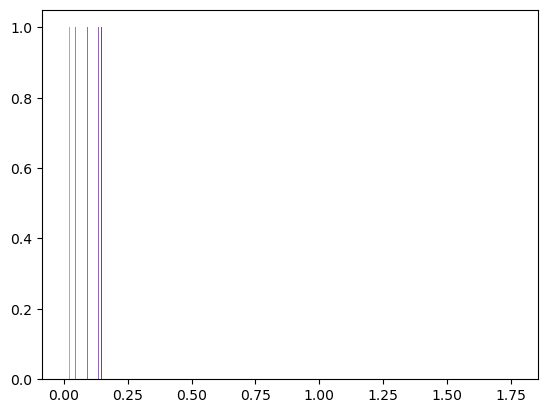

In [ ]:
plt.figure()
plt.hist(replay_sv, bins=50)
plt.show()